# Idealized Case 3: Brownian Motion of Cells 

This tutorial shows how tobac can be used to track a large set of Brownian cells. The follwoing chapters will be covered:

1. [Input Data](#1.-Input-Data)
2. [Feature Detection](#2.-Feature-Detection)
3. [Tracking / Trajectory Linking](#3.-Trajectory-Linking)
4. [Segmentation](#4.-Segmentation)
5. [Statistical Analysis](#5.-Statistical-Analysis)

## Imports and Data Creation

In [1]:
import tobac
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr
import seaborn as sns
from scipy.ndimage import gaussian_filter
from matplotlib.animation import FuncAnimation

sns.set_context("talk")
np.random.seed(12345)

Defining the grid we will work on:

In [2]:
x_min, y_min, x_max, y_max, = 0, 0, 10, 10
t_min, t_max = 0, 100

N_x = 200
N_y = 200
frames = 50

x = np.linspace(x_min, x_max, N_x)
y = np.linspace(y_min, y_max, N_y)
t = np.linspace(t_min, t_max, frames)

yy, xx = np.meshgrid(y, x, indexing='ij')

Brownian cells have temporally and spatially uncorrelated velocities. To simulate this, we create a list of positions iteratively by choosing distances and angles to move froma uniform distribution:

In [3]:
def create_brownian_features(x_0, y_0):
    
    x = x_0
    y = y_0
    
    pos_list = []
    
    for i in range(len(t)):
        ds = np.random.random()*0.3
        angle = np.random.random()*2*np.pi
        dx = ds*np.cos(angle)
        dy = ds*np.sin(angle)
        x+=dx
        y+=dy
        pos_list.append((x, y))
    
    return np.array(pos_list)

The result plotted on a 2d-domain looks like this:

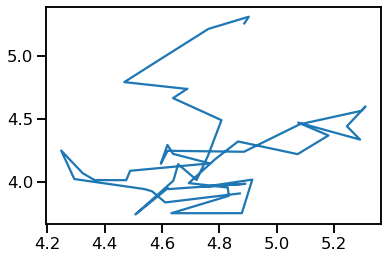

In [4]:
%matplotlib inline

features = create_brownian_features(5, 5)
plt.plot(features.T[0], features.T[1])

We now need to generate an actual datafield from these positions. The simplest approach is to use our positions as the center of a gaussian and to apply a threshold to create a boolean mask afterwards:

In [5]:
def create_array_from_features(features):
    
    data = np.array([np.exp(-((xx-x)**2 + (yy-y)**2)/0.1) for x, y in features])
    return data > 0.5

Our brownian cell will look like this:

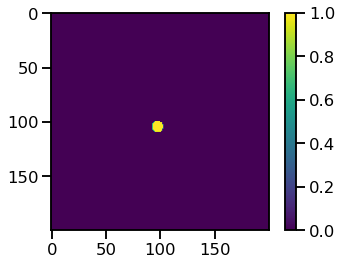

In [6]:
data = create_array_from_features(features)

plt.imshow(data[0])
plt.colorbar()

The last thing we need to do in order to use our data as input for `tobac`, is to convert it to an `xarray`-DataArray. For this we need to set a start time a time delta betwenn our frames. To convention for the names of x- and y-coordinate in `tobac` is 'projection_x_coordinate' resp. 'projection_y_coordinate'.

In [7]:
def create_xarray(array):

    t_0 = np.datetime64('2022-10-01T00:00')
    t_delta = np.timedelta64(100, 'ms')
    time = np.array([t_0 + i*t_delta for i in range(len(array))])
    
    coords = {'time':time,
             'projection_x_coordinate':x,
             'projection_y_coordinate':y
             }
    
    attributes = {'units': ('m s-1')}
    
    data = xr.DataArray(data=array, 
                        coords=coords,  
                        attrs=attributes)
    return data

Let's check our result with an animation:

<IPython.core.display.Javascript object>


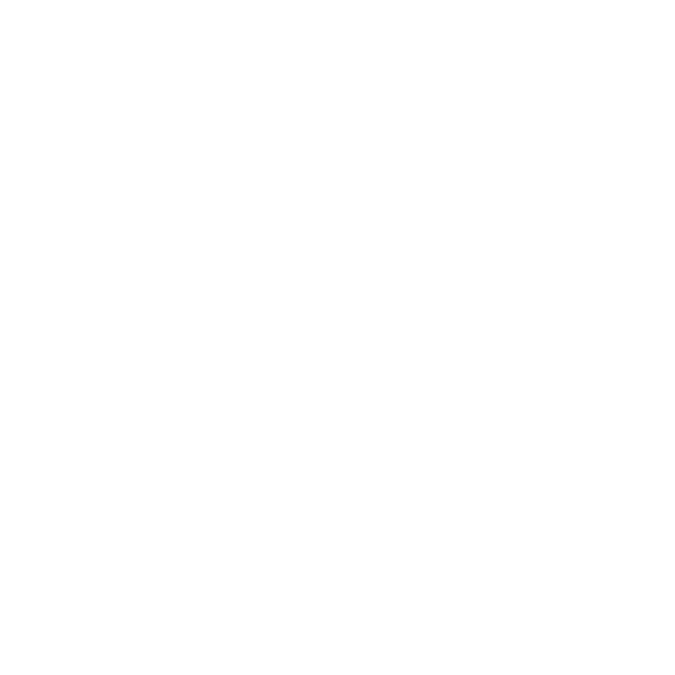

In [8]:
%matplotlib notebook

data = create_xarray(data)

fig, ax = plt.subplots(figsize = (5, 5))

def animate(i):
    data[i].plot.imshow(ax = ax, add_colorbar=False)
    
anim = FuncAnimation(fig, animate, frames = 50)

## Feature detection

Since our cells are trapped in a 2d-domain, they are not able to overlap. So, let's create 50 of those cells following this rule:

In [9]:
N = 0

while N < 51:
    
    if N == 0:
    
        features = create_brownian_features(np.random.random()*10, np.random.random()*10)
        data = create_array_from_features(features)
        final_data = data
        N += 1
        
    else:
        
        features = create_brownian_features(np.random.random()*10, np.random.random()*10)
        data = create_array_from_features(features)
        
        if np.all(np.logical_not(np.logical_and(data, final_data))):
        
            final_data = np.logical_or(final_data, data)
            N +=1

final_data = np.array(final_data, dtype='float64')

To make our dataset a little bit emore realistics, we apply a gaussian filter and ad some noise:

In [10]:
data = gaussian_filter(create_xarray(final_data), 0.4)
noise = 0.2 * np.random.randn(*data.shape)

In [11]:
data += noise

<IPython.core.display.Javascript object>


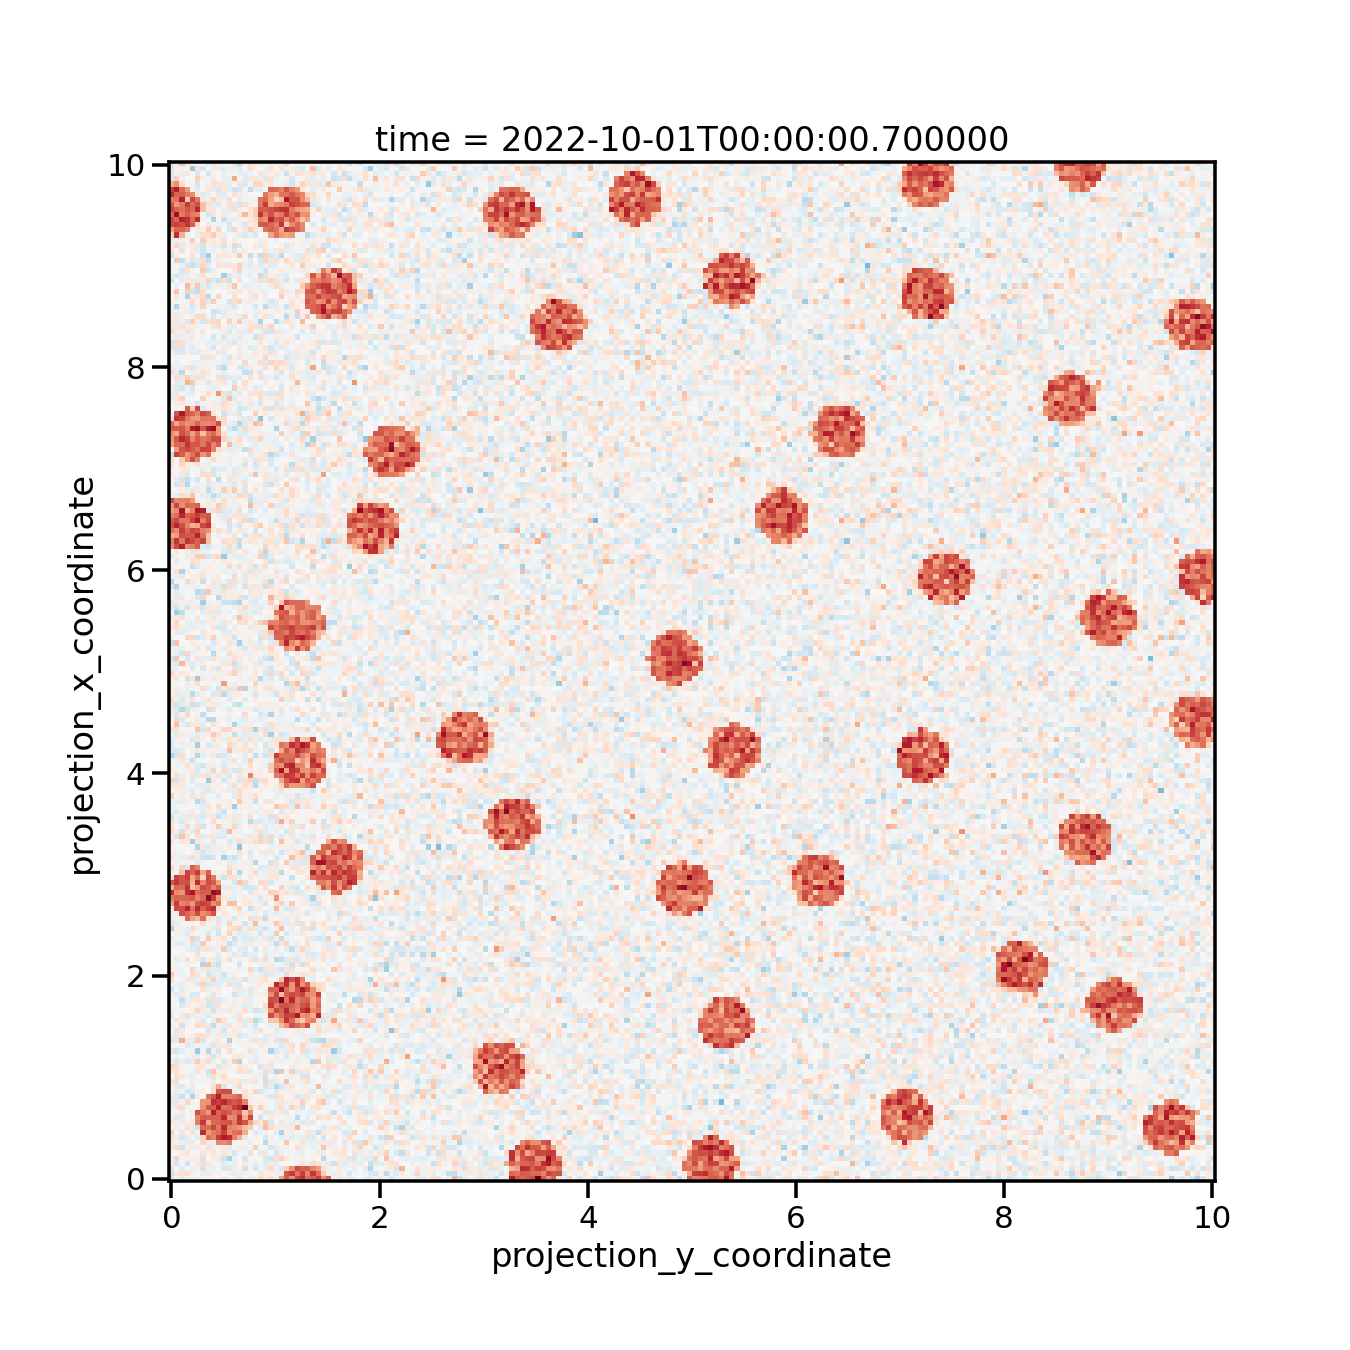

/home/nils/anaconda3/envs/tob_v2/lib/python3.7/site-packages/matplotlib/animation.py:890: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  'Animation was deleted without rendering anything. This is '


In [100]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook
fig, ax = plt.subplots(figsize = (10, 10))

def animate(i):
    #ax.imshow(data[i])
    data[i].plot.imshow(ax = ax, add_colorbar=False)
    
anim = FuncAnimation(fig, animate, frames = 50)

In [13]:
data = create_xarray(data)

The first step of our data analysis is to detect the features of our data. 
Additionally we will need to provide the spacing of our grid.

In [154]:
%%capture

dxy, dt = tobac.utils.get_spacings(data, grid_spacing = x_max/N_x)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, 
                                                                  dxy, 
                                                                  n_erosion_threshold=1, 
                                                                  threshold=0.5, 
                                                                  sigma_threshold=0.5)

In [155]:
features

<xarray.Dataset>
Dimensions:                  (index: 2122)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 ... 2118 2119 2120 2121
Data variables:
    frame                    (index) int64 0 0 0 0 0 0 0 ... 49 49 49 49 49 49
    idx                      (index) int64 1 2 3 4 5 6 7 ... 32 33 34 35 36 37
    hdim_1                   (index) float64 1.167 2.094 3.192 ... 194.7 195.9
    hdim_2                   (index) float64 25.77 97.09 165.2 ... 113.5 131.3
    num                      (index) int64 30 53 73 85 85 85 ... 83 86 84 84 69
    threshold_value          (index) float64 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    feature                  (index) int64 1 2 3 4 5 ... 2119 2120 2121 2122
    time                     (index) object 2022-10-01 00:00:00 ... 2022-10-0...
    timestr                  (index) object '2022-10-01 00:00:00' ... '2022-1...
    projection_x_coordinate  (index) float64 0.05863 0.1052 ... 9.782 9.843
    projection_y_coordinate  (index) float64 1.295 4.879 8.301 ... 5.704 6.599

Frame 49: 37 trajectories present.


Text(0.5, 1.0, 'predict')

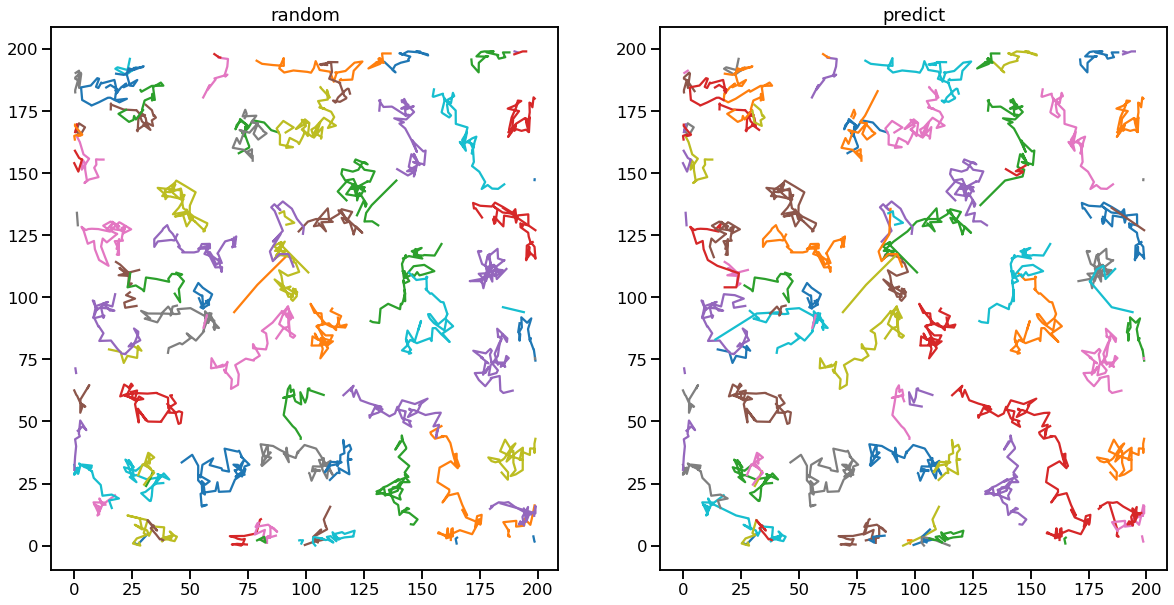

In [156]:
%matplotlib inline


#mask, features = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=0.3)

track1 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=1,
                                              method_linking='random',
                                              subnetwork_size=100)

track2 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=1, 
                                              method_linking='predict',
                                              subnetwork_size=100)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 10))

#ax1.imshow(blob[0], cmap = 'Greys', alpha = 0)
#ax2.imshow(blob[0], cmap = 'Greys', alpha = 0)

"""for i, track_i in track1.groupby('cell'):

    track_i.plot.scatter(
        x="projection_x_coordinate",
        y="projection_y_coordinate",
        ax=ax1,
        marker="x",
        label="cell {0}".format(int(i)),
    ) """
#ax1.legend()
for i, track_i in track1.groupby('cell'):
    ax1.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='',
            linestyle='-')
#ax2.legend()
ax1.set_title('random')

for i, track_i in track2.groupby('cell'):
    ax2.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='',
            linestyle='-')
#ax2.legend()
ax2.set_title('predict')

Text(0.5, 1.0, 'filtered')

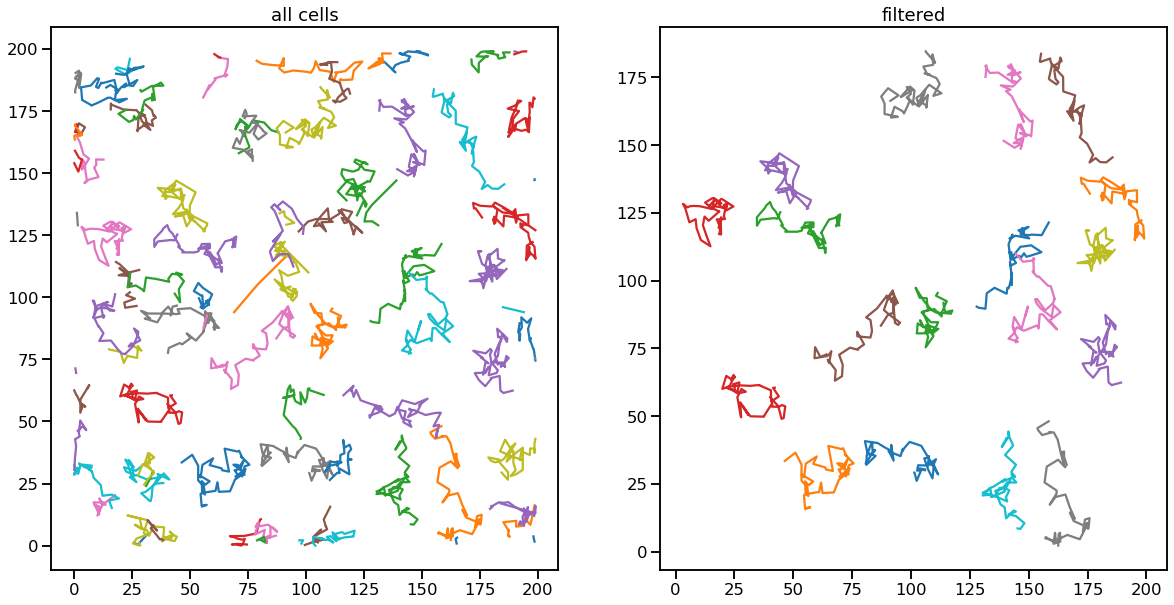

In [157]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 10))

for i, track_i in track1.groupby('cell'):
    ax1.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='',
            linestyle='-')
#ax2.legend()
ax1.set_title('all cells')

for i, track_i in track1.groupby('cell'):
    if len(track_i['frame']) == 50:
        ax2.plot(track_i.sortby('frame')['hdim_2'], 
                 track_i.sortby('frame')['hdim_1'],
                label='cell {}'.format(int(i)),
                marker ='',
                linestyle='-')
#ax2.legend()
ax2.set_title('filtered')

In [158]:
n=0
for i, track_i in track1.groupby('cell'):
    if len(track_i['frame']) == 50:
        n +=1
print(n)

18


In [40]:
track1

<xarray.Dataset>
Dimensions:                  (index: 1975)
Coordinates:
  * index                    (index) int64 0 27 28 29 30 ... 1952 1953 1945 1974
Data variables: (12/13)
    frame                    (index) int64 0 0 0 0 0 0 0 ... 49 49 49 49 49 49
    idx                      (index) int64 1 28 29 30 31 32 ... 13 14 15 16 8 37
    hdim_1                   (index) float64 0.5455 121.9 122.6 ... 33.18 197.0
    hdim_2                   (index) float64 26.45 158.8 198.8 ... 81.18 131.5
    num                      (index) int64 11 38 5 33 38 34 ... 36 33 35 34 31
    threshold_value          (index) float64 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3
    ...                       ...
    time                     (index) object 2022-10-01 00:00:00 ... 2022-10-0...
    timestr                  (index) object '2022-10-01 00:00:00' ... '2022-1...
    projection_x_coordinate  (index) float64 0.02741 6.125 6.161 ... 1.667 9.898
    projection_y_coordinate  (index) float64 1.329 7.982 9.99 ... 4.079 6.61
    cell                     (index) float64 1.0 2.0 3.0 4.0 ... 77.0 42.0 73.0
    time_cell                (index) timedelta64[ns] 00:00:00 ... 00:00:01

In [41]:
features

<xarray.Dataset>
Dimensions:                  (index: 1975)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 ... 1971 1972 1973 1974
Data variables:
    frame                    (index) int64 0 0 0 0 0 0 0 ... 49 49 49 49 49 49
    idx                      (index) int64 1 2 3 4 5 6 7 ... 32 33 34 35 36 37
    hdim_1                   (index) float64 0.5455 1.429 2.632 ... 195.5 197.0
    hdim_2                   (index) float64 26.45 97.5 165.7 ... 114.1 131.5
    num                      (index) int64 11 28 38 43 34 34 ... 29 32 35 38 31
    threshold_value          (index) float64 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3
    feature                  (index) int64 1 2 3 4 5 ... 1972 1973 1974 1975
    time                     (index) object 2022-10-01 00:00:00 ... 2022-10-0...
    timestr                  (index) object '2022-10-01 00:00:00' ... '2022-1...
    projection_x_coordinate  (index) float64 0.02741 0.07179 ... 9.824 9.898
    projection_y_coordinate  (index) float64 1.329 4.899 8.325 ... 5.731 6.61

In [42]:
n=0
for i, track_i in track1.groupby('cell'):
    if len(track_i['frame']) == 50:
        n +=1
print(n)

26


In [48]:
track1

<xarray.Dataset>
Dimensions:                  (index: 2447)
Coordinates:
  * index                    (index) int64 0 27 28 29 30 ... 2419 2420 2422 2446
Data variables: (12/13)
    frame                    (index) int64 0 0 0 0 0 0 0 ... 50 50 50 50 50 50
    idx                      (index) int64 1 28 29 30 31 32 ... 19 20 21 23 47
    hdim_1                   (index) float64 3.853 99.2 110.7 ... 99.5 198.6
    hdim_2                   (index) float64 99.39 24.8 14.5 ... 162.6 153.5
    num                      (index) int64 116 149 150 239 ... 150 151 152 10
    threshold_value          (index) float64 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    ...                       ...
    time                     (index) object 2022-04-01 00:00:00 ... 2022-04-0...
    timestr                  (index) object '2022-04-01 00:00:00' ... '2022-0...
    projection_x_coordinate  (index) float64 0.1936 4.985 5.563 ... 5.0 9.98
    projection_y_coordinate  (index) float64 4.994 1.246 0.7286 ... 8.172 7.714
    cell                     (index) float64 1.0 2.0 3.0 ... 23.0 161.0 158.0
    time_cell                (index) timedelta64[ns] 00:00:00 ... 00:01:00

In [96]:
np.unique(track1['cell'].data)

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141.])

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [56]:
data

<xarray.DataArray (time: 51, projection_x_coordinate: 200, projection_y_coordinate: 200)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.63445798e-03, 1.38363811e-07, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.63156347e-03, 1.38363811e-07, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.63143630e-03, 1.38363811e-07, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.87596003e-02, 3.28723082e-06, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.87594731e-02, 3.28723082e-06, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.87594675e-02, 3.28723082e-06, 0.00000000e+00]]])
Coordinates:
  * time                     (time) datetime64[ns] 2022-04-01 ... 2022-04-01T...
  * projection_x_coordinate  (projection_x_coordinate) float64 0.0 ... 10.0
  * projection_y_coordinate  (projection_y_coordinate) float64 0.0 ... 10.0
Attributes:
    units:    m s-1